In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

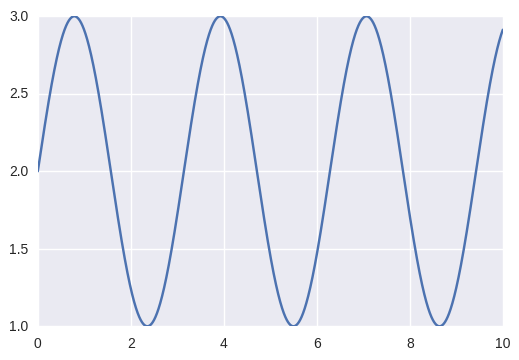

In [3]:
def sin_sample(a=2, b=2, N=5000):
    x_samples = np.linspace(0, 10, N)
    samples = np.sin(a*x_samples) + b
    return x_samples, samples
    
xs, ys = sin_sample()
plt.plot(xs, ys)

In [4]:
k=2 
x0=10
a=-2
b=2
N=5000

In [5]:
TRAIN_ITERS=10000
M=200 # minibatch size

In [6]:
def mlp(input, output_dim):
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    
    fc1=tf.nn.tanh(tf.matmul(input,w1) + b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2) + b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3) + b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [7]:
def momentum_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                
        batch,  
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                
        staircase=True)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

In [8]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D-train_labels))

In [9]:
optimizer=momentum_optimizer(loss,None)

In [10]:
sess=tf.InteractiveSession()
tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [11]:
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    
    xs, ys = sin_sample()
    ax.plot(xs, ys, label='p_data')
    
    r=1000 
    xs=np.linspace(-2*np.pi,2*np.pi,r)
    ds=np.zeros((r,1)) 
    for i in range(r/M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(-2,2)
    plt.legend()

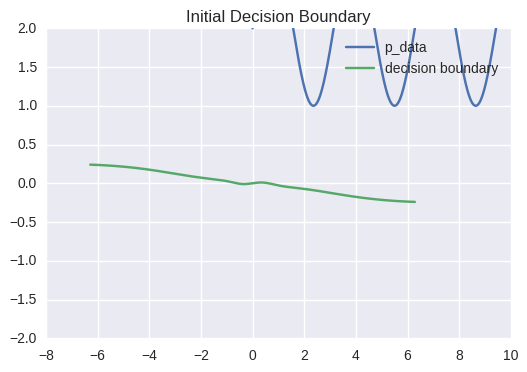

In [12]:
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')

In [13]:
lh=np.zeros(N)
for i in range(N):
    d=(np.random.random(M)-0.5) * 10.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
    labels=k*np.sin(d+x0)
    lh[i],_=sess.run([loss,optimizer], {input_node: np.reshape(d,(M,1)), train_labels: np.reshape(labels,(M,1))})

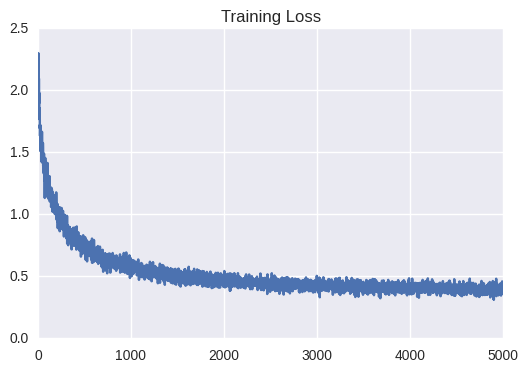

In [14]:
plt.plot(lh)
plt.title('Training Loss')

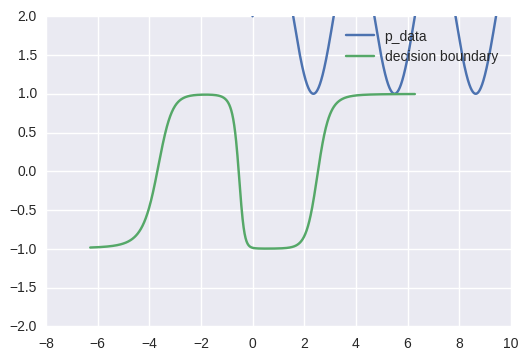

In [15]:
plot_d0(D,input_node)

In [16]:
weightsD=sess.run(theta)
sess.close()

In [17]:
with tf.variable_scope("G"):
    z_node=tf.placeholder(tf.float32, shape=(M,1)) 
    G,theta_g=mlp(z_node,1) 
    G=tf.mul(5.0,G)
with tf.variable_scope("D") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(M,1))
    fc,theta_d=mlp(x_node,1) 
    D1=tf.maximum(tf.minimum(fc,.99), 0.01)
    
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)
obj_d=tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g=tf.reduce_mean(tf.log(D2))
 
opt_d=momentum_optimizer(1-obj_d, theta_d)
opt_g=momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

In [18]:
sess=tf.InteractiveSession()
tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [19]:
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [20]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs, ys=sin_sample()
    ax.plot(xs, ys, label='p_data')

    
    r=5000 
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1))
    
    for i in range(r/M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

s
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(r/M):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(-2, 2)
    plt.legend()

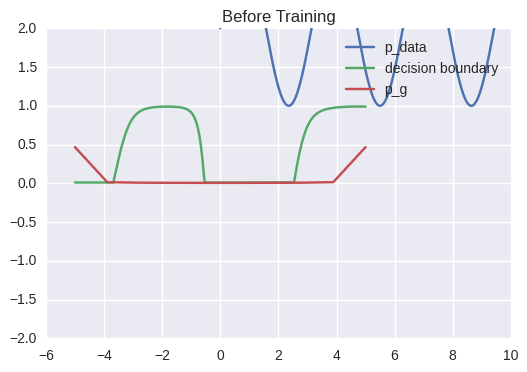

In [21]:
plot_fig()
plt.title('Before Training')

In [ ]:
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.random(M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], {x_node: np.reshape(x,(M,1)), z_node: np.reshape(z,(M,1))})
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], {z_node: np.reshape(z,(M,1))}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

In [ ]:
plt.plot(range(TRAIN_ITERS),histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

In [ ]:
plot_fig()